In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./glove.840B.300d.txt
./smartstoplist.txt
./sms-spam-detection-mnb-lstm-gru-bi-lstm.ipynb
./spam.csv
./.ipynb_checkpoints\sms-spam-detection-mnb-lstm-gru-bi-lstm-checkpoint.ipynb


# Importing Required Libraries

In [2]:
!pip install scikit-plot



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [4]:
df_ = pd.read_csv("./spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df = df_.copy()
df.columns = ["label", "text"]
df = df[["text", "label"]]
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [5]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [6]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 5572
COLS: 2


**##################### TYPES ######################**

text     object
label     int64
dtype: object


**################# MISSING VALUES #################**

text     0
label    0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 403


**################## MEMORY USAGE ##################**

Memory Usage: 87.2+ KB


In [7]:
df = df.drop_duplicates()

# Exploratory Data Analysis

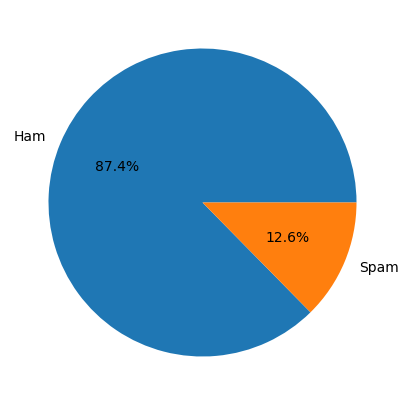

In [8]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Ham", "Spam"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

In [9]:
def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

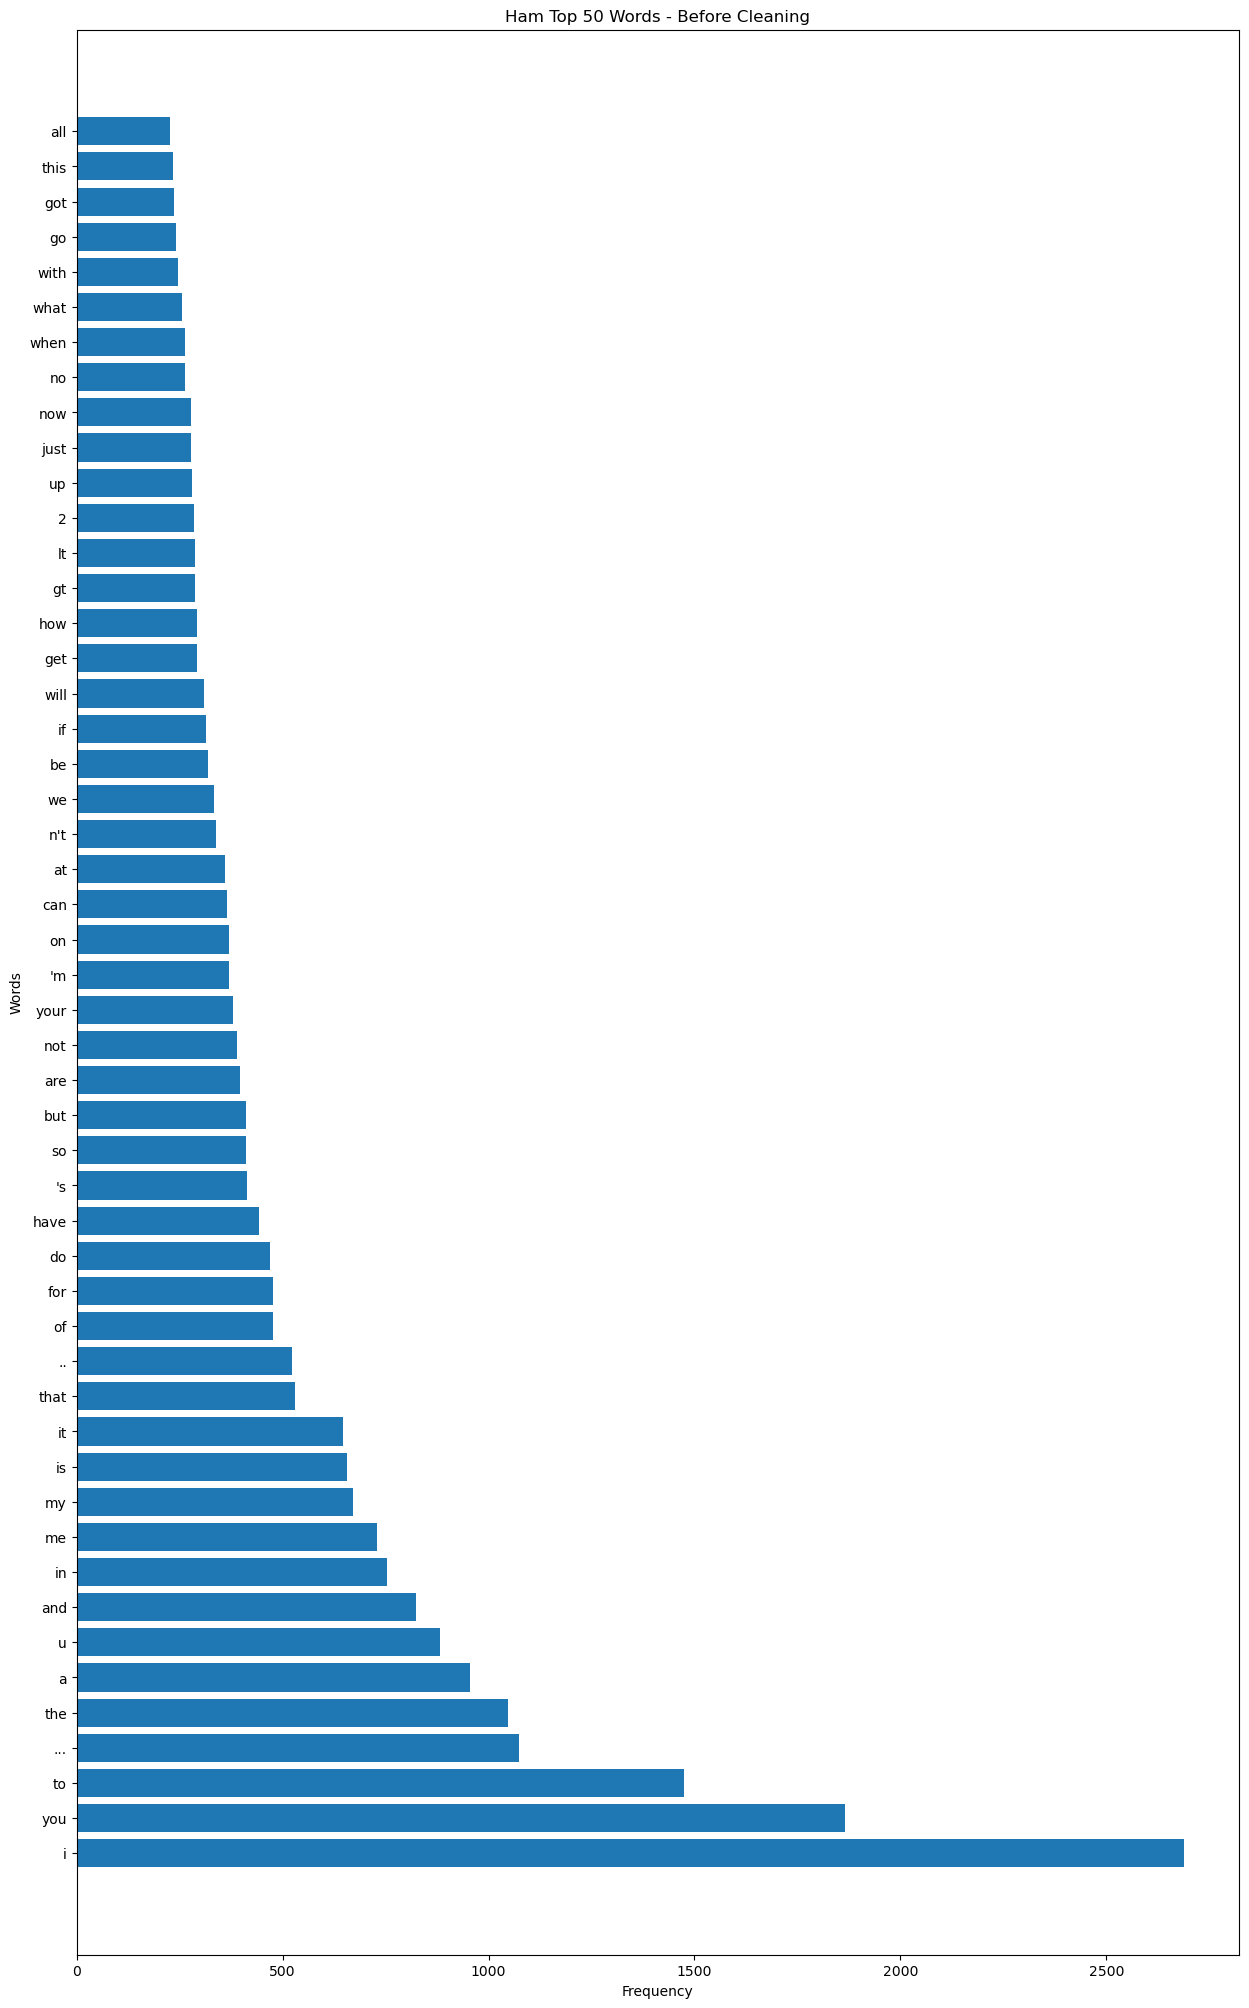

In [10]:
ham_freq_top = word_freq(df, 0, "text", "Ham Top 50 Words - Before Cleaning")

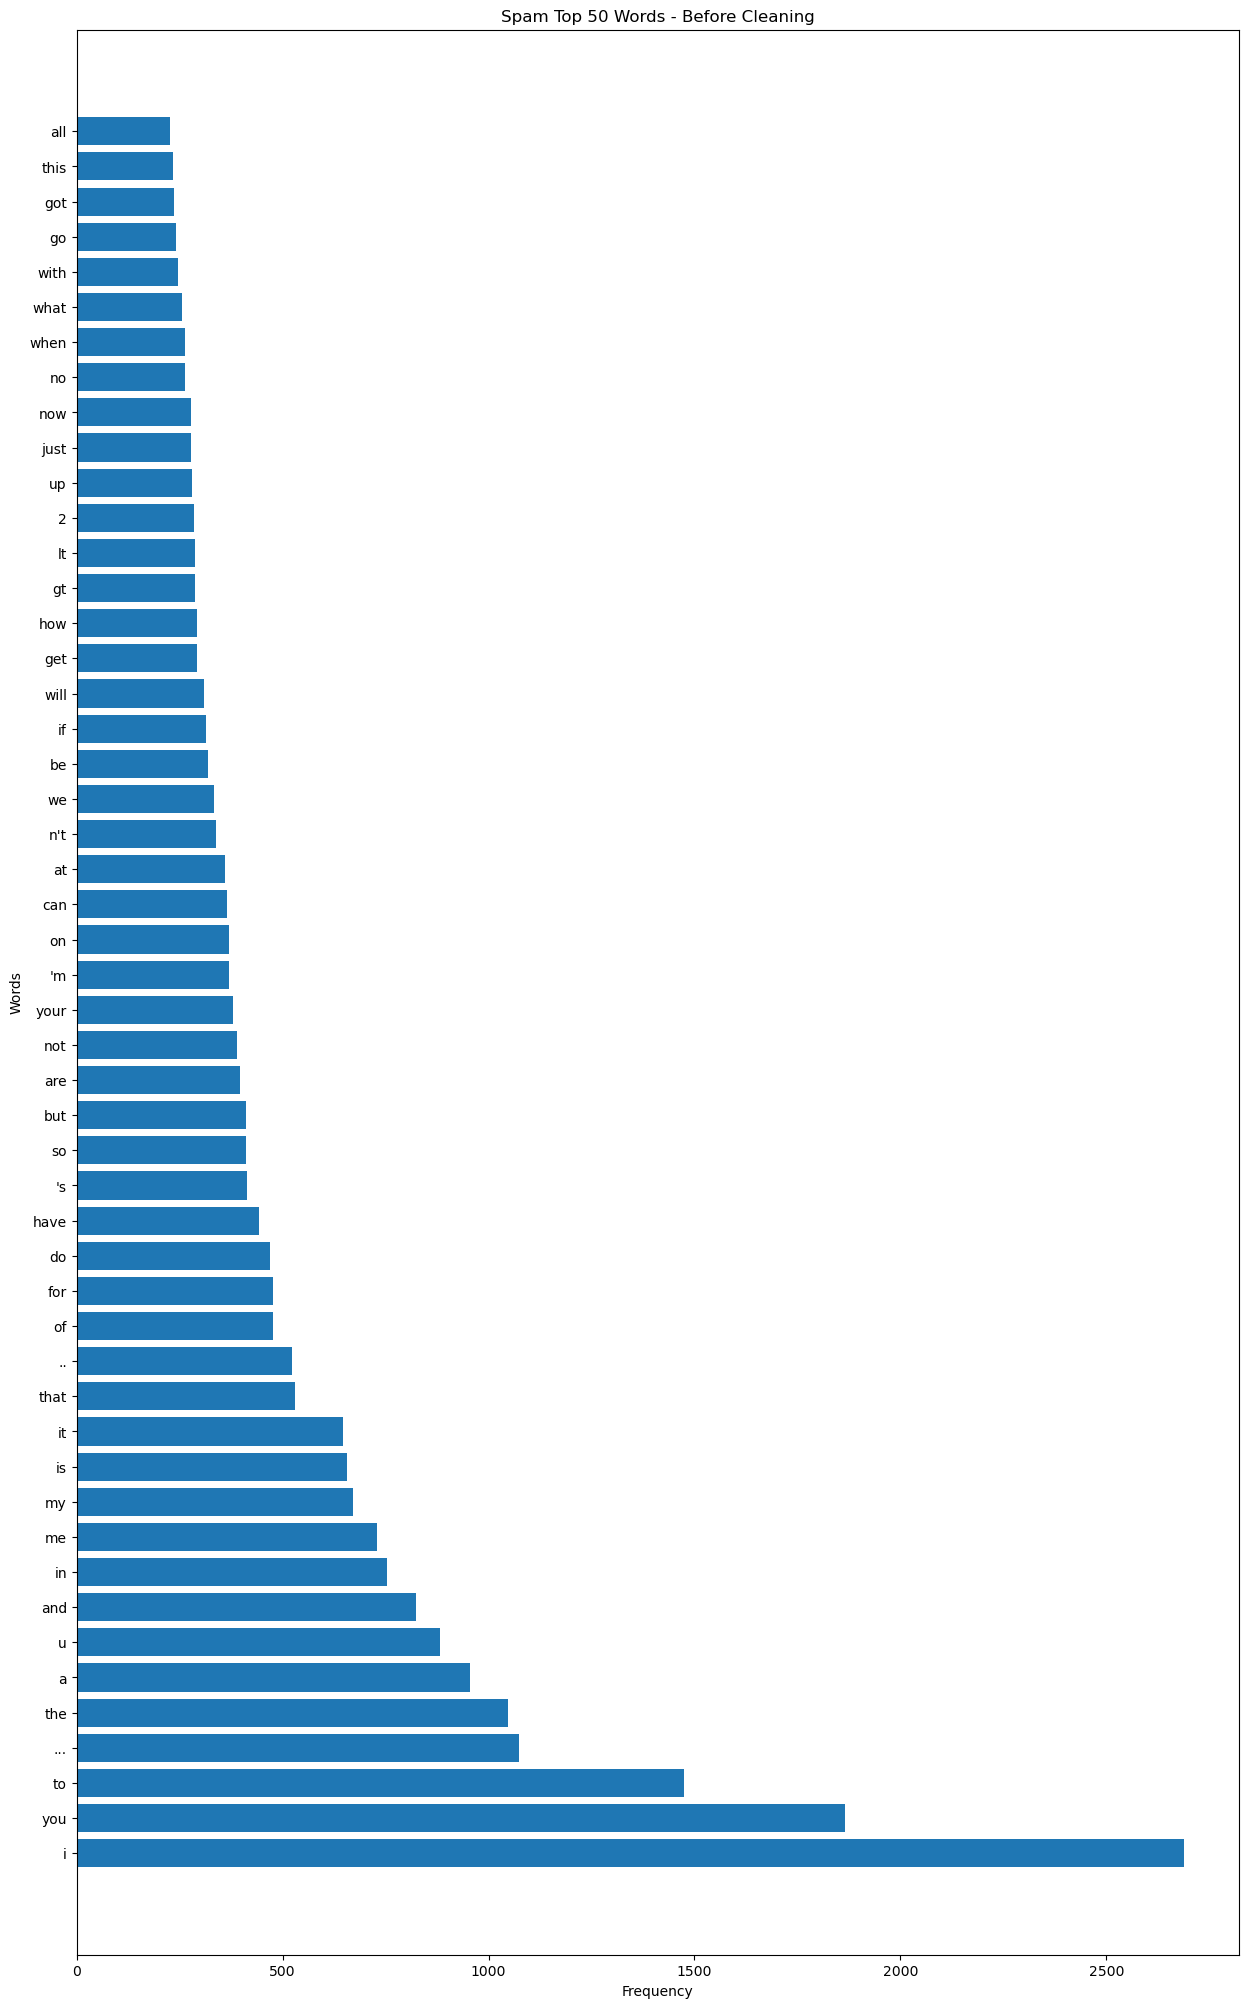

In [11]:
spam_freq_top = word_freq(df, 0, "text", "Spam Top 50 Words - Before Cleaning")

In [12]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

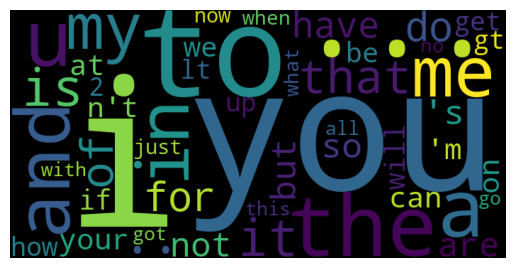

In [13]:
print_wordcloud(ham_freq_top)

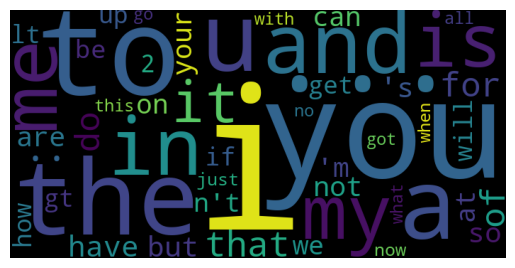

In [14]:
print_wordcloud(spam_freq_top)

# Preprocess

In [15]:
stop_words = set(stopwords.words("english"))

In [16]:
smart_words = "./smartstoplist.txt"

In [17]:
smart_stoplist = []

In [18]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [19]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [20]:
smart_stoplist.append("_")

In [21]:
!ls -l /usr/share/nltk_data/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
#nltk.download("all")
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
df["clean"] = df["text"].apply(clean)

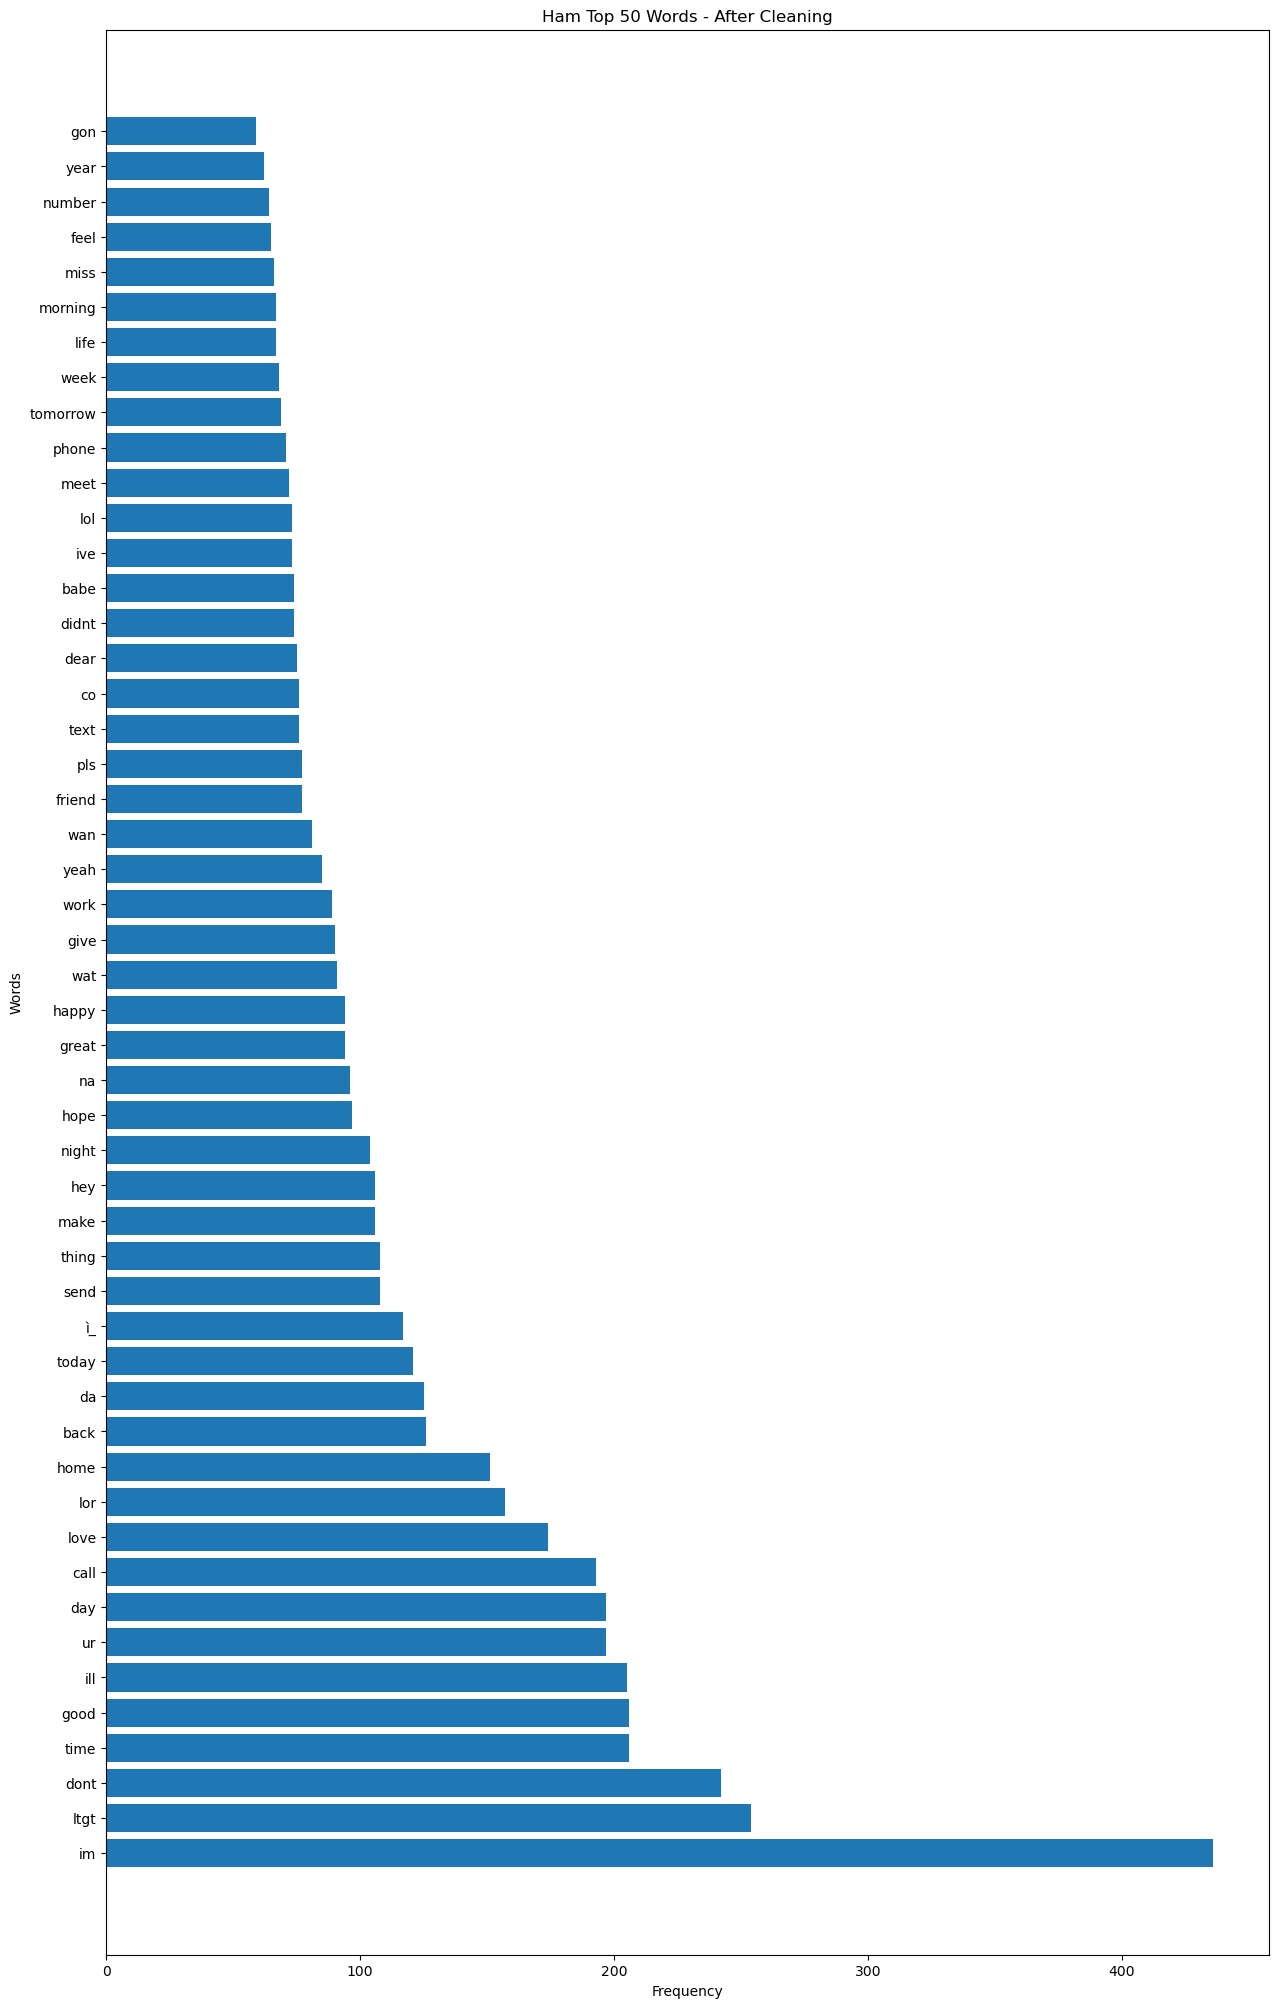

In [24]:
clean_ham_freq_top = word_freq(df, 0, "clean", "Ham Top 50 Words - After Cleaning")

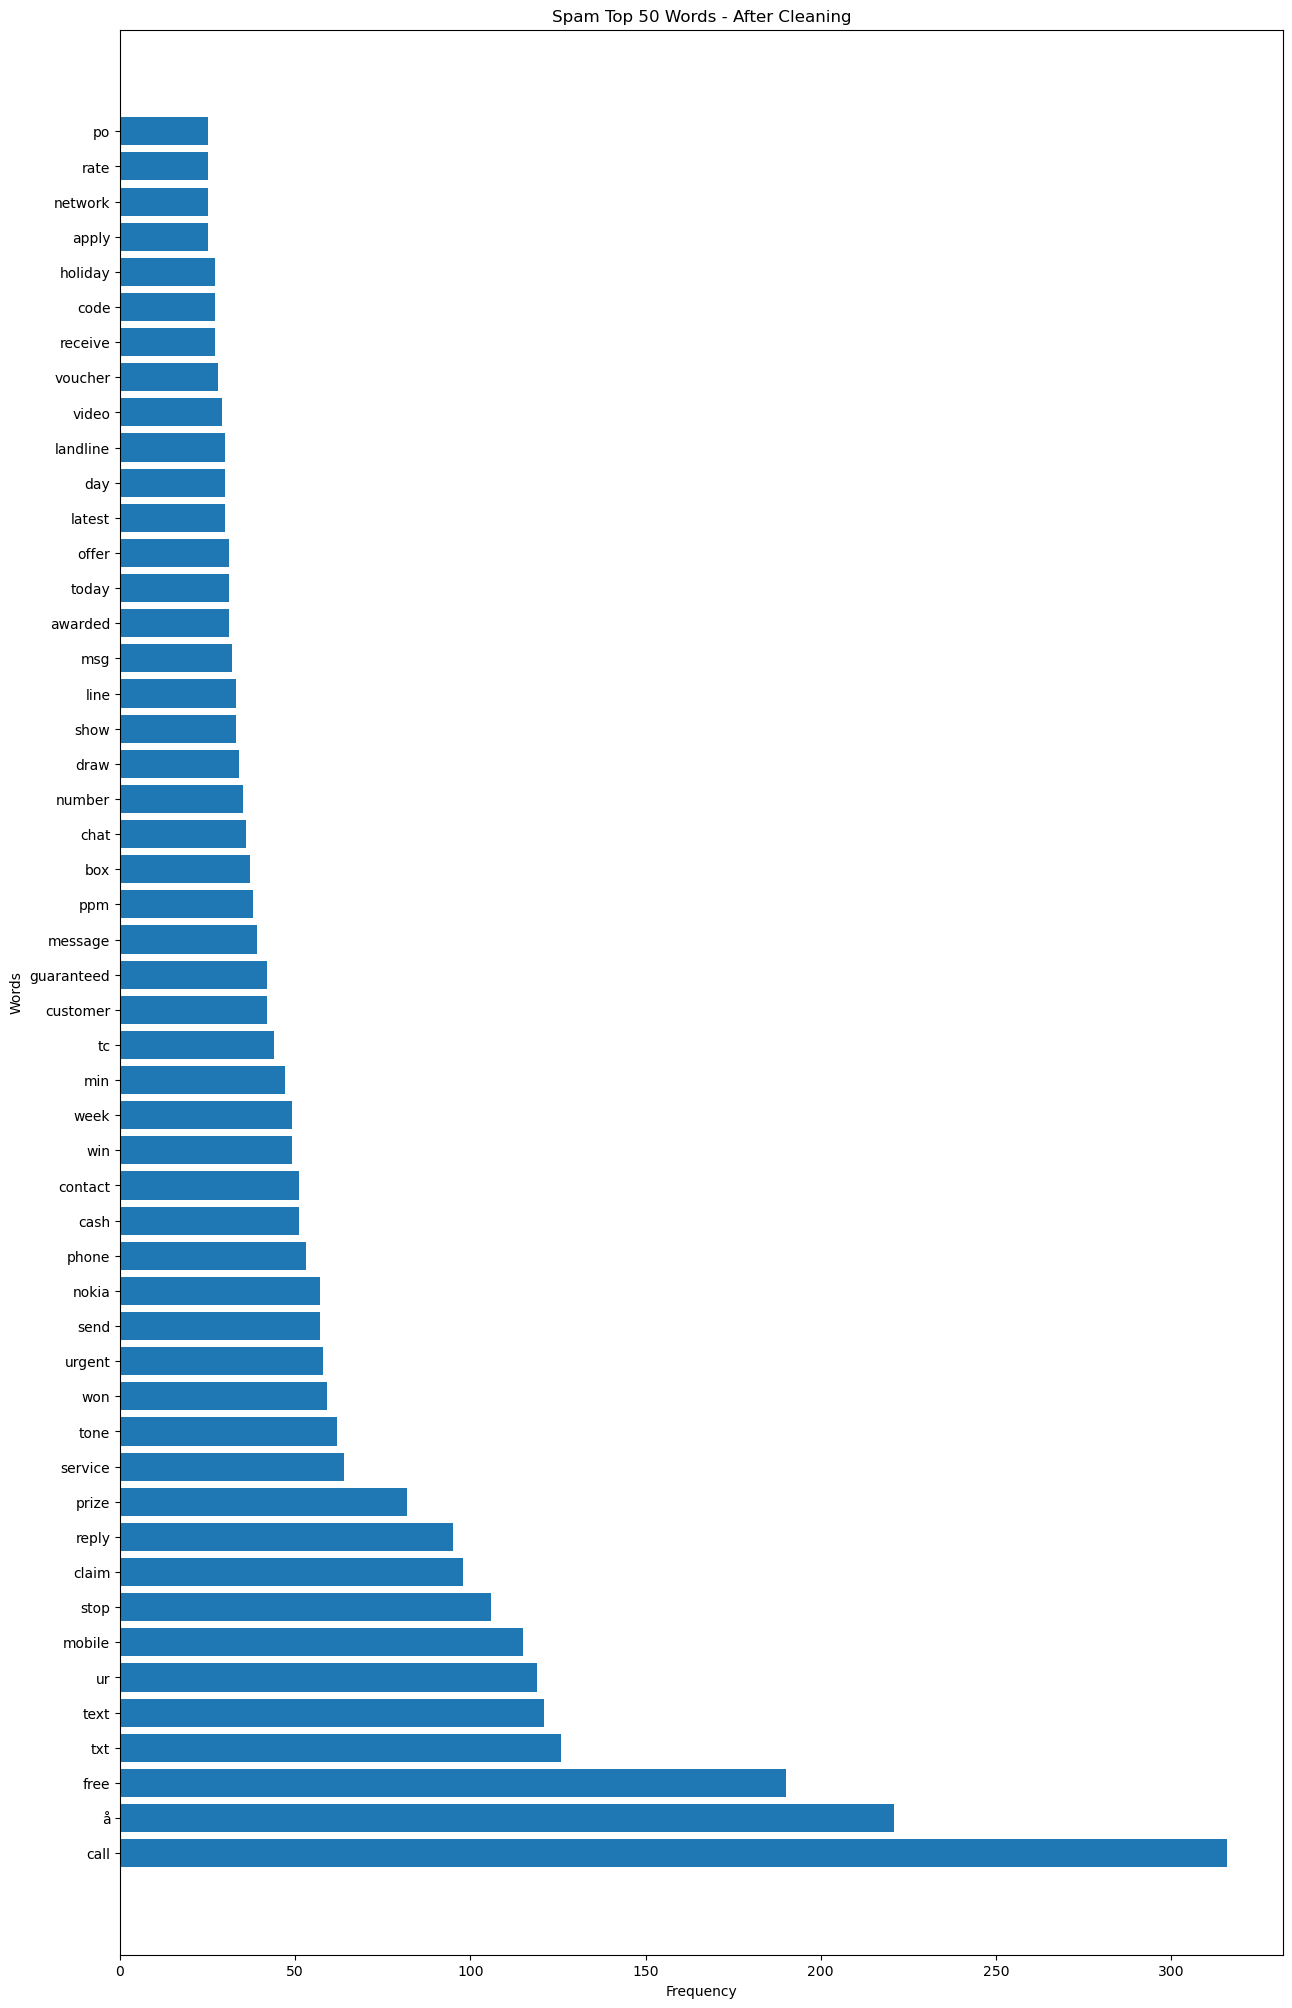

In [25]:
clean_spam_freq_top = word_freq(df, 1, "clean", "Spam Top 50 Words - After Cleaning")

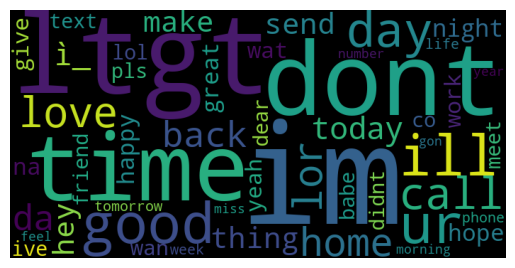

In [26]:
print_wordcloud(clean_ham_freq_top)

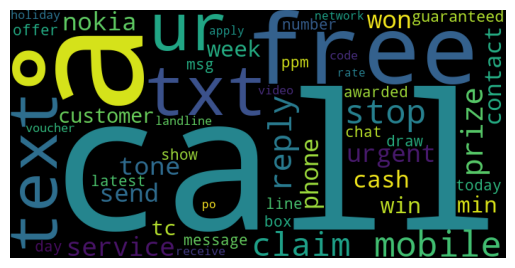

In [27]:
print_wordcloud(clean_spam_freq_top)

# Feature Scaling

In [28]:
X = df["clean"]
y = df["label"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [32]:
maxlen = 70

In [33]:
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [34]:
word_index = tokenizer.word_index
len(word_index)

7643

In [35]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [36]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [37]:
embeddings_index = {}
f = open("./glove.840B.300d.txt", "r", encoding="utf-8")
for line in tqdm.tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs

f.close()
print("Found %s word vectors." % len(embeddings_index))

2196018it [07:02, 5202.79it/s]

Found 2196017 word vectors.


In [38]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████████████████████████████████████████████████████████████████████| 7643/7643 [00:00<00:00, 201637.05it/s]


# Models

# TFIDF + MultinomialNB

In [39]:
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_end = time.time()
mnb_tfidf_train_time = mnb_tfidf_train_end - mnb_tfidf_train_start
print("TFIDF + MultnomialNB Train Time = ", mnb_tfidf_train_time)

TFIDF + MultnomialNB Train Time =  0.00799417495727539


In [40]:
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_test_start = time.time()
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
mnb_tfidf_test_end = time.time()
mnb_tfidf_test_time = mnb_tfidf_test_end - mnb_tfidf_test_start

mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)
print(f"TFIDF + MultinomialNB Train Score = {mnb_tfidf_train_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Score = {mnb_tfidf_test_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Time = ", mnb_tfidf_test_time)

TFIDF + MultinomialNB Train Score = 97.07%
TFIDF + MultinomialNB Test Score = 95.84%
TFIDF + MultinomialNB Test Time =  0.0


In [41]:
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)

print(f"TFIDF + MultinomialNB Precision Score = {mnb_tfidf_precision_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB F1 Score = {mnb_tfidf_f1_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Recall Score = {mnb_tfidf_recall_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Accuracy Score = {mnb_tfidf_accuracy_score * 100:.2f}%")

TFIDF + MultinomialNB Precision Score = 100.00%
TFIDF + MultinomialNB F1 Score = 82.59%
TFIDF + MultinomialNB Recall Score = 70.34%
TFIDF + MultinomialNB Accuracy Score = 95.84%


In [42]:
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       889
        spam       1.00      0.70      0.83       145

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



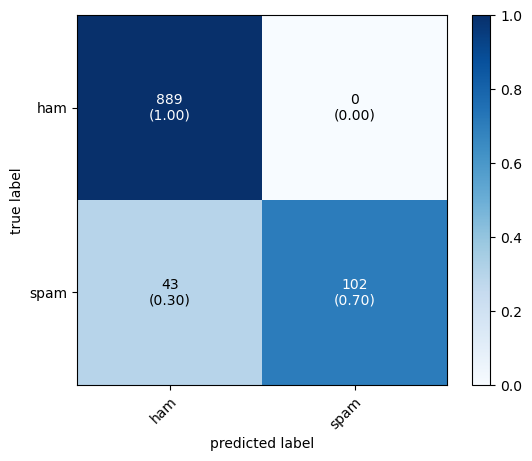

In [43]:
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

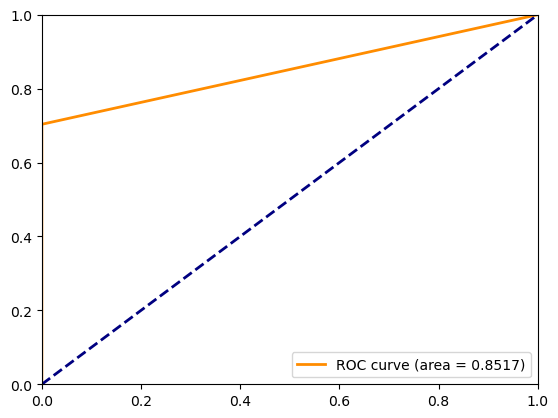

In [44]:
fpr, tpr, _ = roc_curve(y_test, mnb_tfidf_pred_test)
mnb_tfidf_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_tfidf_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# CV + MultinomialNB

In [45]:
mnb = MultinomialNB()
mnb_cv_train_start = time.time()
mnb.fit(X_train_cv, y_train)
mnb_cv_train_end = time.time()
mnb_cv_train_time = mnb_cv_train_end - mnb_cv_train_start
print("CV + MultinomialNB Train Time = ", mnb_cv_train_time)

CV + MultinomialNB Train Time =  0.017945528030395508


In [46]:
mnb_cv_pred_train = mnb.predict(X_train_cv)
mnb_cv_test_start = time.time()
mnb_cv_pred_test = mnb.predict(X_test_cv)
mnb_cv_test_end = time.time()
mnb_cv_test_time = mnb_cv_test_end - mnb_cv_test_start

mnb_cv_train_score = accuracy_score(mnb_cv_pred_train, y_train)
mnb_cv_test_score = accuracy_score(mnb_cv_pred_test, y_test)
print(f"CV + MultinomialNB Train Score = {mnb_cv_train_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Score = {mnb_cv_test_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Time = ", mnb_cv_test_time)

CV + MultinomialNB Train Score = 98.96%
CV + MultinomialNB Test Score = 97.68%
CV + MultinomialNB Test Time =  0.0010635852813720703


In [47]:
mnb_cv_precision_score = precision_score(y_test, mnb_cv_pred_test)
mnb_cv_f1_score = f1_score(y_test, mnb_cv_pred_test)
mnb_cv_recall_score = recall_score(y_test, mnb_cv_pred_test)
mnb_cv_accuracy_score = accuracy_score(y_test, mnb_cv_pred_test)

print(f"CV + MultinomialNB Precision Score = {mnb_cv_precision_score * 100:.2f}%")
print(f"CV + MultinomialNB F1 Score = {mnb_cv_f1_score * 100:.2f}%")
print(f"CV + MultinomialNB Recall Score = {mnb_cv_recall_score * 100:.2f}%")
print(f"CV + MultinomialNB Accuracy Score = {mnb_cv_accuracy_score * 100:.2f}%")

CV + MultinomialNB Precision Score = 94.16%
CV + MultinomialNB F1 Score = 91.49%
CV + MultinomialNB Recall Score = 88.97%
CV + MultinomialNB Accuracy Score = 97.68%


In [48]:
print(classification_report(y_test, mnb_cv_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.94      0.89      0.91       145

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



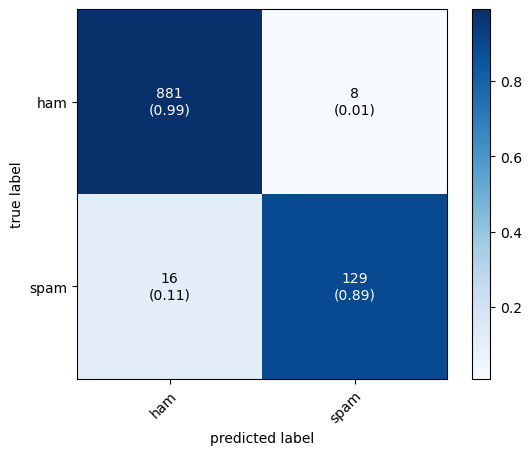

In [49]:
mnb_cv_cm = confusion_matrix(y_test, mnb_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_cv_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

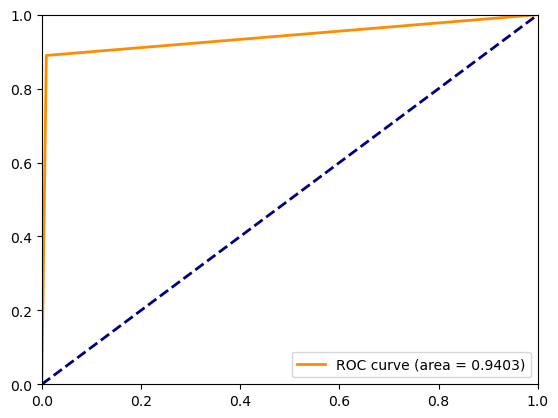

In [50]:
fpr, tpr, _ = roc_curve(y_test, mnb_cv_pred_test)
mnb_cv_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_cv_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# SimpleRNN

In [51]:
from keras.models import Sequential
from keras.layers import Input, Embedding, SimpleRNN, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

# Create a Sequential model
simplernn = Sequential()

# Add layers
simplernn.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
simplernn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape))

# Initialize the Embedding layer with pre-trained word embeddings
simplernn.layers[0].set_weights([embedding_matrix])  # Set weights to the first layer
simplernn.layers[0].trainable = False  # Make the Embedding layer non-trainable

simplernn.add(SimpleRNN(100))
simplernn.add(Dense(1, activation='sigmoid'))

# Compile the model
simplernn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
simplernn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,333,401 (8.90 MB)

 Trainable params: 40,201 (157.04 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [52]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8630 - loss: 0.2960 - val_accuracy: 0.9686 - val_loss: 0.1021
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9712 - loss: 0.0923 - val_accuracy: 0.6063 - val_loss: 0.9194
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8792 - loss: 0.2868 - val_accuracy: 0.9758 - val_loss: 0.1011
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9760 - loss: 0.0951 - val_accuracy: 0.9807 - val_loss: 0.0863
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9822 - loss: 0.0644 - val_accuracy: 0.9807 - val_loss: 0.0791
Model1 Train Time =  14.978085041046143


In [53]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Model1 Test Time =  1.2859878540039062


In [54]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
SimpleRNN Train Score = 98.11%
SimpleRNN Test Score = 97.58%


In [55]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 96.15%
SimpleRNN F1 Score = 90.91%
SimpleRNN Recall Score = 86.21%
SimpleRNN Accuracy Score = 97.58%


In [56]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.96      0.86      0.91       145

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



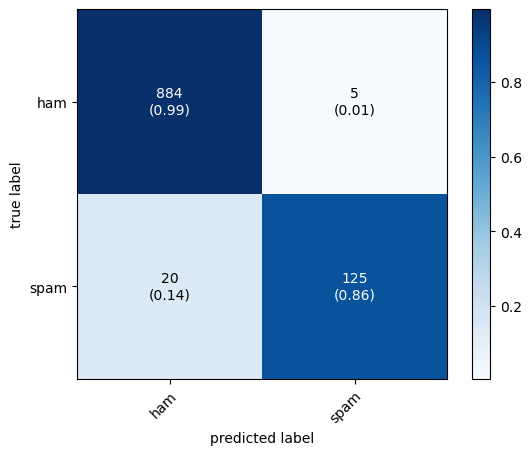

In [57]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

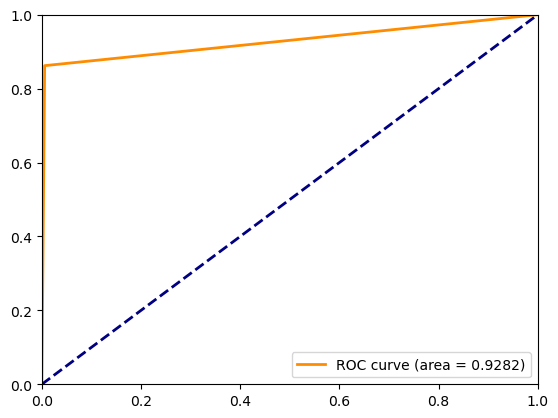

In [58]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# LSTM

In [59]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
lstm = Sequential()

# Add layers
lstm.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
lstm.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
lstm.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
lstm.layers[0].trainable = False  # Make the Embedding layer non-trainable

lstm.add(LSTM(100))
lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,453,701 (9.36 MB)

 Trainable params: 160,501 (626.96 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [60]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8760 - loss: 0.3381 - val_accuracy: 0.9783 - val_loss: 0.0733
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9728 - loss: 0.0852 - val_accuracy: 0.9831 - val_loss: 0.0668
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9858 - loss: 0.0497 - val_accuracy: 0.9855 - val_loss: 0.0492
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9815 - loss: 0.0546 - val_accuracy: 0.9831 - val_loss: 0.0546
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9876 - loss: 0.0350 - val_accuracy: 0.9783 - val_loss: 0.0672
Model2 Train Time =  34.650744915008545


In [61]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Model2 Test Time =  1.9673256874084473


In [62]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
LSTM Train Score = 98.98%
LSTM Test Score = 97.39%


In [63]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 88.31%
LSTM F1 Score = 90.97%
LSTM Recall Score = 93.79%
LSTM Accuracy Score = 97.39%


In [64]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       889
        spam       0.88      0.94      0.91       145

    accuracy                           0.97      1034
   macro avg       0.94      0.96      0.95      1034
weighted avg       0.97      0.97      0.97      1034



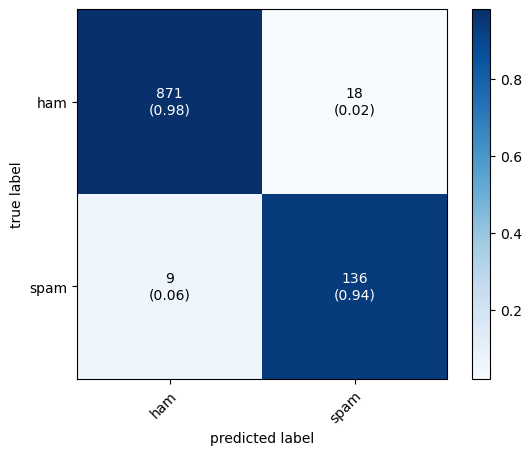

In [65]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

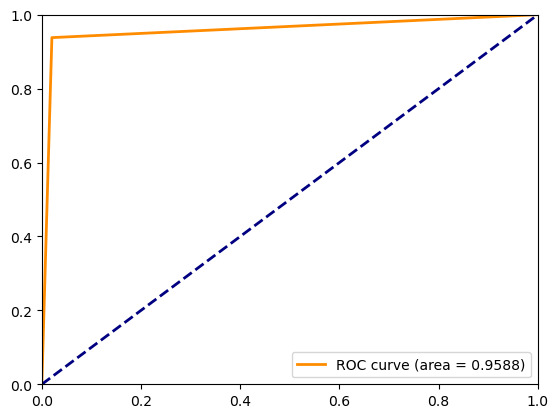

In [66]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# GRU

In [67]:
from keras.models import Sequential
from keras.layers import Input, Embedding, GRU, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
gru = Sequential()

# Add layers
gru.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
gru.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
gru.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
gru.layers[0].trainable = False  # Make the Embedding layer non-trainable

gru.add(GRU(100))
gru.add(Dense(1, activation='sigmoid'))

# Compile the model
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
gru.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100)                 │         120,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,413,901 (9.21 MB)

 Trainable params: 120,701 (471.49 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [68]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.7974 - loss: 0.3911 - val_accuracy: 0.9638 - val_loss: 0.1119
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9664 - loss: 0.1114 - val_accuracy: 0.9783 - val_loss: 0.0571
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9756 - loss: 0.0597 - val_accuracy: 0.9831 - val_loss: 0.0431
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9861 - loss: 0.0450 - val_accuracy: 0.9928 - val_loss: 0.0402
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9874 - loss: 0.0385 - val_accuracy: 0.9928 - val_loss: 0.0372
Model3 Train Time =  37.82707858085632


In [69]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Model3 Test Time =  1.6165006160736084


In [70]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
GRU Train Score = 99.40%
GRU Test Score = 98.07%


In [71]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 98.45%
GRU F1 Score = 92.70%
GRU Recall Score = 87.59%
GRU Accuracy Score = 98.07%


In [72]:
print(classification_report(y_test, gru_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       0.98      0.88      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



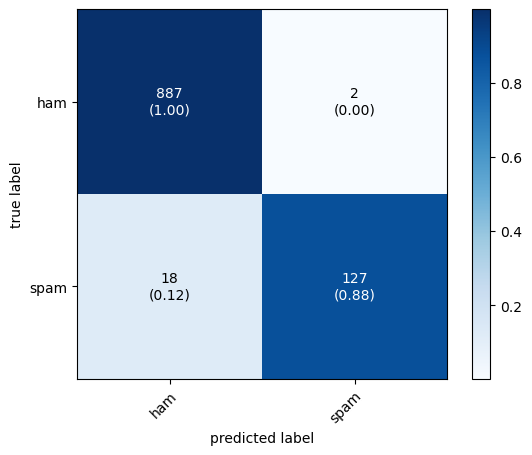

In [73]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

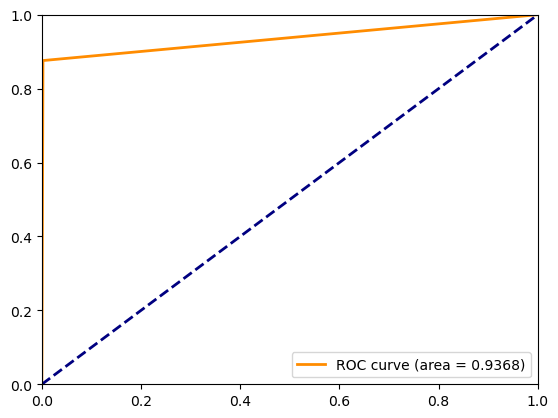

In [74]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Bi-LSTM

In [75]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
bilstm = Sequential()

# Add layers
bilstm.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
bilstm.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
bilstm.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
bilstm.layers[0].trainable = False  # Make the Embedding layer non-trainable

bilstm.add(Bidirectional(LSTM(100, return_sequences=True)))
bilstm.add(GlobalMaxPooling1D())
bilstm.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
bilstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 70, 200)             │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,614,201 (9.97 MB)

 Trainable params: 321,001 (1.22 MB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [76]:
model4_train_start = time.time()
bilstm_results = bilstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model4_train_end = time.time()
model4_train_time = model4_train_end - model4_train_start
print("Model4 Train Time = ", model4_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.8632 - loss: 0.3711 - val_accuracy: 0.9758 - val_loss: 0.1013
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9689 - loss: 0.1036 - val_accuracy: 0.9807 - val_loss: 0.0707
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9784 - loss: 0.0667 - val_accuracy: 0.9879 - val_loss: 0.0514
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9845 - loss: 0.0514 - val_accuracy: 0.9903 - val_loss: 0.0392
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9941 - loss: 0.0323 - val_accuracy: 0.9879 - val_loss: 0.0387
Model4 Train Time =  46.69435405731201


In [77]:
model4_test_start = time.time()
bilstm_pred_test = bilstm.predict(X_test_tokenizer)
model4_test_end = time.time()
model4_test_time = model4_test_end - model4_test_start
print("Model4 Test Time = ", model4_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Model4 Test Time =  2.4874649047851562


In [78]:
bilstm_pred_train = bilstm.predict(X_train_tokenizer)
bilstm_pred_train = [1 if i > 0.5 else 0 for i in bilstm_pred_train]
bilstm_pred_test = [1 if i > 0.5 else 0 for i in bilstm_pred_test]
bilstm_train_score = accuracy_score(bilstm_pred_train, y_train)
bilstm_test_score = accuracy_score(bilstm_pred_test, y_test)
print(f"BILSTM Train Score = {bilstm_train_score * 100:.2f}%")
print(f"BILSTM Test Score = {bilstm_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
BILSTM Train Score = 99.25%
BILSTM Test Score = 98.26%


In [79]:
bilstm_precision_score = precision_score(y_test, bilstm_pred_test)
bilstm_f1_score = f1_score(y_test, bilstm_pred_test)
bilstm_recall_score = recall_score(y_test, bilstm_pred_test)
bilstm_accuracy_score = accuracy_score(y_test, bilstm_pred_test)

print(f"BILSTM Precision Score = {bilstm_precision_score * 100:.2f}%")
print(f"BILSTM F1 Score = {bilstm_f1_score * 100:.2f}%")
print(f"BILSTM Recall Score = {bilstm_recall_score * 100:.2f}%")
print(f"BILSTM Accuracy Score = {bilstm_accuracy_score * 100:.2f}%")

BILSTM Precision Score = 97.04%
BILSTM F1 Score = 93.57%
BILSTM Recall Score = 90.34%
BILSTM Accuracy Score = 98.26%


In [80]:
print(classification_report(y_test, bilstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       0.97      0.90      0.94       145

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



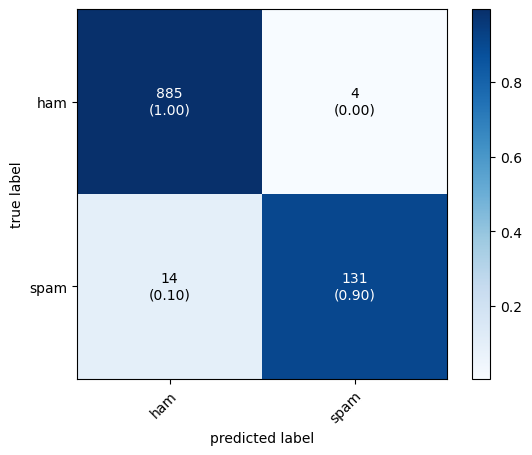

In [81]:
bilstm_cm = confusion_matrix(y_test, bilstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bilstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

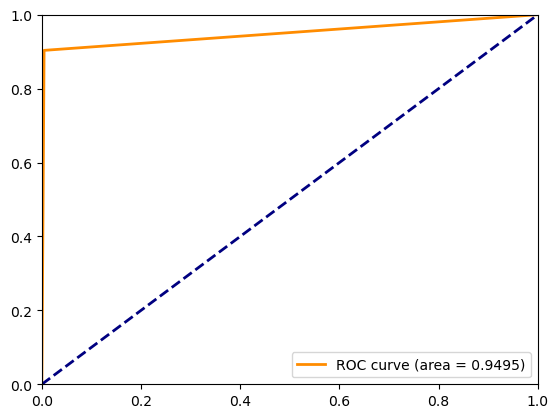

In [82]:
fpr, tpr, _ = roc_curve(y_test, bilstm_pred_test)
bilstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bilstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Results

In [83]:
scores_df = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [84]:
scores_df.loc[0] = ["MultinomialNB + TFIDF",
                    mnb_tfidf_train_time,
                    mnb_tfidf_test_time,
                    mnb_tfidf_train_score,
                    mnb_tfidf_test_score,
                    mnb_tfidf_accuracy_score,
                    mnb_tfidf_f1_score,
                    mnb_tfidf_precision_score,
                    mnb_tfidf_recall_score,
                    mnb_tfidf_roc_auc]

In [85]:
scores_df.loc[1] = ["MultinomialNB + CountVectorizer",
                    mnb_cv_train_time,
                    mnb_cv_test_time,
                    mnb_cv_train_score,
                    mnb_cv_test_score,
                    mnb_cv_accuracy_score,
                    mnb_cv_f1_score,
                    mnb_cv_precision_score,
                    mnb_cv_recall_score,
                    mnb_cv_roc_auc]

In [86]:
scores_df.loc[2] = ["SimpleRNN + GloVe",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [87]:
scores_df.loc[3] = ["LSTM + GloVe",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [88]:
scores_df.loc[4] = ["GRU + GloVe",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [89]:
scores_df.loc[5] = ["Bi-LSTM + GloVe",
                    model4_train_time,
                    model4_test_time,
                    bilstm_train_score,
                    bilstm_test_score,
                    bilstm_accuracy_score,
                    bilstm_f1_score,
                    bilstm_precision_score,
                    bilstm_recall_score,
                    bilstm_roc_auc]

In [90]:
scores_df

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
0,MultinomialNB + TFIDF,0.007994,0.000000,0.970738,0.958414,0.958414,0.825911,1.000000,0.703448,0.851724
1,MultinomialNB + CountVectorizer,0.017946,0.001064,0.989601,0.976789,0.976789,0.914894,0.941606,0.889655,0.940328
2,SimpleRNN + GloVe,14.978085,1.285988,0.981137,0.975822,0.975822,0.909091,0.961538,0.862069,0.928222
3,LSTM + GloVe,34.650745,1.967326,0.989843,0.973888,0.973888,0.909699,0.883117,0.937931,0.958842
4,GRU + GloVe,37.827079,1.616501,0.993954,0.980658,0.980658,0.927007,0.984496,0.875862,0.936806
5,Bi-LSTM + GloVe,46.694354,2.487465,0.992503,0.982592,0.982592,0.935714,0.970370,0.903448,0.949474


In [96]:
import pickle
import tensorflow as tf

# Save the model architecture as JSON
model_json = bilstm.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
bilstm.save_weights("model_weights.weights.h5")

# Save the TF-IDF vectorizer
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

# Save the entire model in the SavedModel format
tf.saved_model.save(bilstm, 'path/to/save/model')


INFO:tensorflow:Assets written to: path/to/save/model\assets


INFO:tensorflow:Assets written to: path/to/save/model\assets
